In [1]:
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

data_path = r"C:\Users\devireddy ramreddy\Downloads\archive (1)\US_Accidents_March23.csv"

df = pd.read_csv(data_path, low_memory=False)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)

✅ Dataset loaded successfully!
Shape: (7728394, 46)


In [3]:
df = df.dropna(subset=['Weather_Condition', 'Start_Time', 'Start_Lat', 'Start_Lng']).copy()

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time'])
df['Hour'] = df['Start_Time'].dt.hour

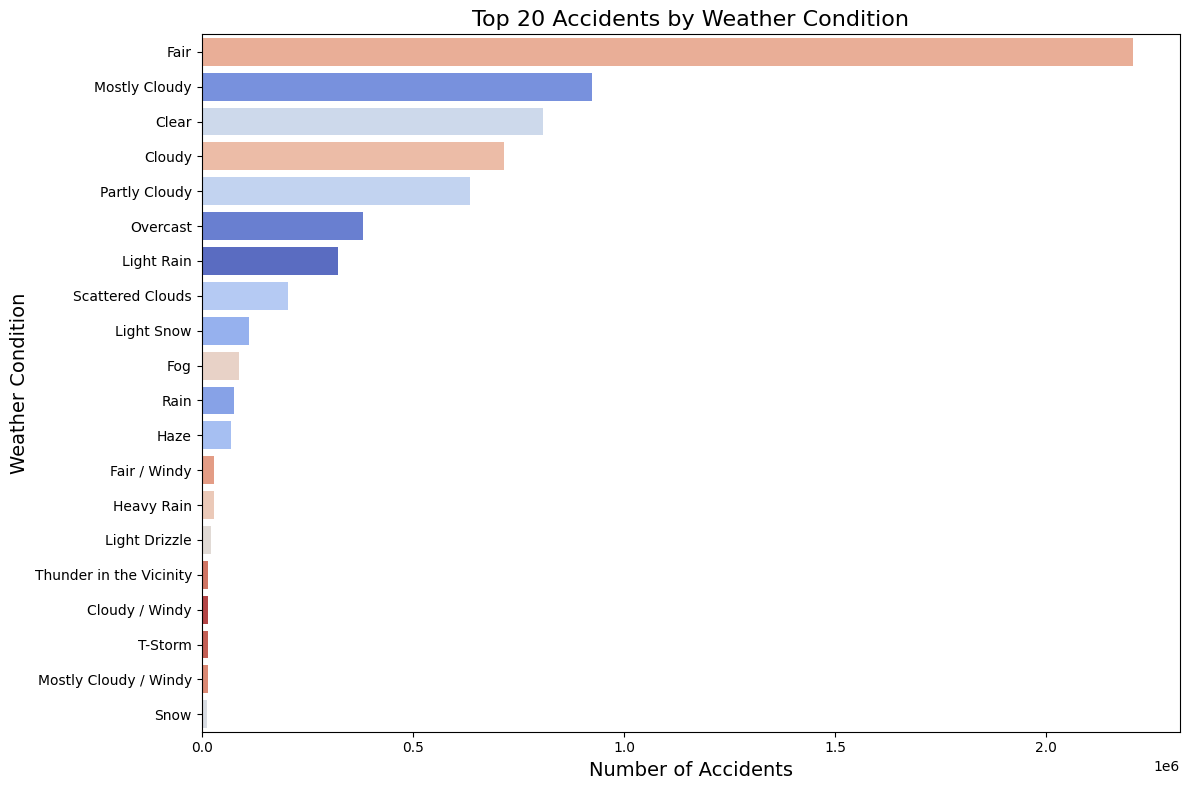

In [4]:
top_conditions = df['Weather_Condition'].value_counts().nlargest(20).index

plt.figure(figsize=(12, 8))
sns.countplot(
    y='Weather_Condition',
    data=df[df['Weather_Condition'].isin(top_conditions)],
    order=top_conditions,
    hue='Weather_Condition',  
    palette='coolwarm',
    legend=False            
)

plt.title("Top 20 Accidents by Weather Condition", fontsize=16)
plt.xlabel("Number of Accidents", fontsize=14)
plt.ylabel("Weather Condition", fontsize=14)

plt.tight_layout()
plt.show()

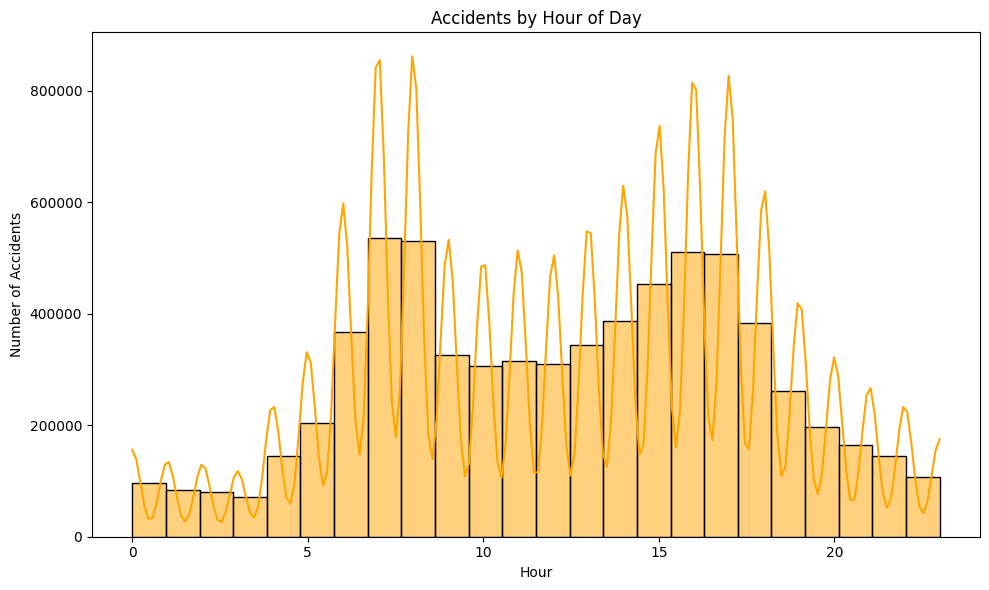

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(df['Hour'], bins=24, kde=True, color='orange')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

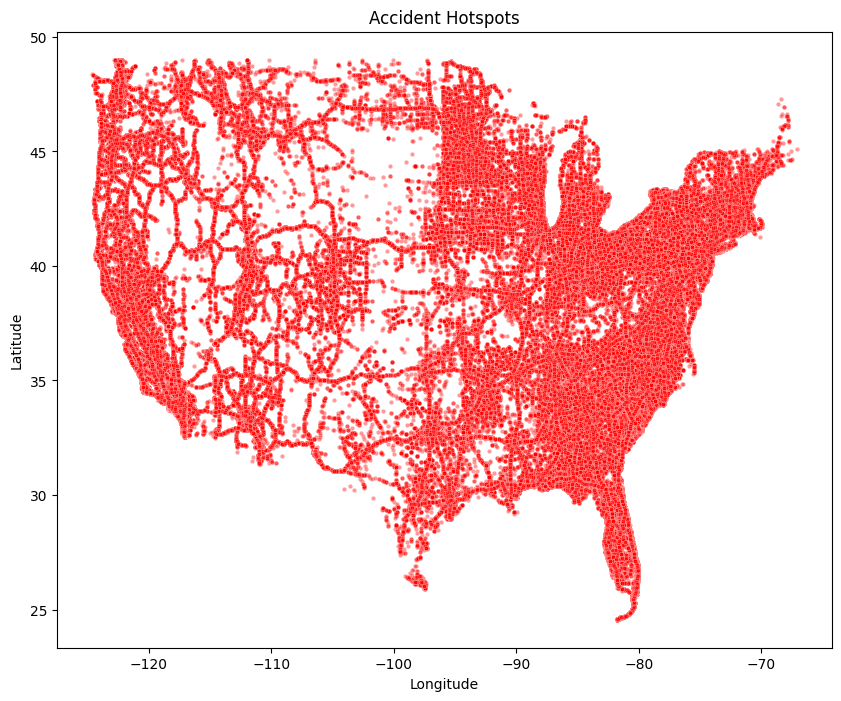

In [6]:
df_locations = df.dropna(subset=['Start_Lat', 'Start_Lng'])

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Start_Lng', 
    y='Start_Lat', 
    data=df_locations, 
    s=10,          
    alpha=0.4,     
    color='red'
)
plt.title("Accident Hotspots")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

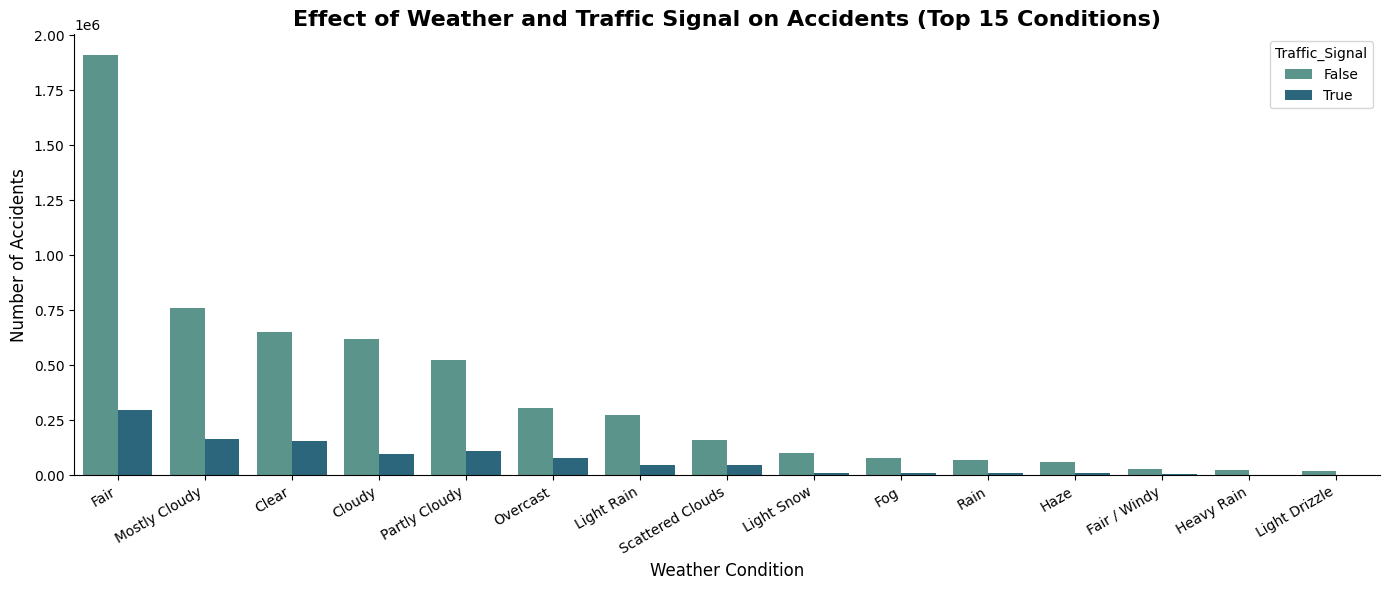

In [7]:
import difflib

weather_col = difflib.get_close_matches('weather_condition', df.columns, n=1)
traffic_col = difflib.get_close_matches('traffic_signal', df.columns, n=1)

if not weather_col or not traffic_col:
    raise KeyError("Required columns not found. Please check column names.")

weather_col = weather_col[0]
traffic_col = traffic_col[0]

df_grouped = df.groupby([weather_col, traffic_col], observed=True).size().reset_index(name='accident_count')

top_conditions = (
    df_grouped.groupby(weather_col, observed=True)['accident_count']
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)

df_top = df_grouped[df_grouped[weather_col].isin(top_conditions)].copy()
df_top[weather_col] = pd.Categorical(df_top[weather_col], categories=top_conditions, ordered=True)
N_KEEP = 8
top_traffic = (
    df_top.groupby(traffic_col, observed=True)['accident_count']
    .sum()
    .sort_values(ascending=False)
    .head(N_KEEP)
    .index
)
df_top[traffic_col] = df_top[traffic_col].where(df_top[traffic_col].isin(top_traffic), other='Other')

df_plot = df_top.groupby([weather_col, traffic_col], as_index=False, observed=True)['accident_count'].sum()

plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_plot,
    x=weather_col,
    y='accident_count',
    hue=traffic_col,
    palette=sns.color_palette("crest", n_colors=len(df_plot[traffic_col].unique())),
    errorbar=None
)
plt.title('Effect of Weather and Traffic Signal on Accidents (Top 15 Conditions)', fontsize=16, weight='bold')
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.legend(title=traffic_col, loc='upper right')
sns.despine()
plt.tight_layout()
plt.show()
